In [4]:
import pandas as pd
import os
import numpy as np
os.chdir('/home/tm_ba/Desktop/Bachelorarbeit_code')

In [14]:
df = pd.read_csv("csv_new/processed_Trajectories.csv")
df = df.rename(columns={"Recording": "Sequence"}).drop("Sub Frame", axis=1)
df

,Frame,Mathew:shoulder:X (mm),Mathew:shoulder:Y (mm),Mathew:shoulder:Z (mm),Mathew:shoulderElbowSupport:X (mm),Mathew:shoulderElbowSupport:Y (mm),Mathew:shoulderElbowSupport:Z (mm),Mathew:elbow:X (mm),Mathew:elbow:Y (mm),Mathew:elbow:Z (mm),...,Mathew:elbowWrist:X (mm),Mathew:elbowWrist:Y (mm),Mathew:elbowWrist:Z (mm),Mathew:Triangle2:X (mm),Mathew:Triangle2:Y (mm),Mathew:Triangle2:Z (mm),Mathew:ThumbTip:X (mm),Mathew:ThumbTip:Y (mm),Mathew:ThumbTip:Z (mm),Sequence
0,1,424.573,31.46390,632.820,468.277,46.7705,443.600,437.244,95.0522,303.700,...,396.319,145.3050,191.947,246.222,197.514,74.8402,208.065,226.836,58.5300,0.0
1,2,424.260,31.44500,632.718,467.946,47.3265,443.768,436.375,95.5444,304.092,...,394.630,146.3600,192.751,244.034,197.688,75.1489,205.831,226.619,58.8733,0.0
2,3,424.073,31.44570,632.837,467.521,47.7943,443.758,435.643,96.2625,304.070,...,393.247,147.4150,193.529,241.699,197.913,76.6041,203.393,225.856,59.2708,0.0
3,4,423.898,31.59660,632.891,467.049,48.2684,443.627,434.516,96.9949,304.057,...,391.708,148.0680,194.022,239.639,198.164,78.2239,200.365,225.176,59.9573,0.0
4,5,423.604,31.65990,632.974,466.561,48.8856,443.475,433.747,97.6751,303.587,...,390.033,149.0990,194.498,237.279,198.358,78.9482,197.646,224.697,60.5265,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29035,484,472.782,-7.33897,652.253,535.728,-16.3590,461.963,554.699,35.5385,328.978,...,581.487,93.6361,215.385,552.405,245.451,78.3614,553.403,289.602,36.5813,50.0
29036,485,472.814,-7.35831,652.198,535.742,-16.4615,461.932,554.922,35.4013,329.154,...,581.569,93.5538,215.329,552.566,245.691,78.9424,553.230,289.540,36.6210,50.0
29037,486,472.883,-7.35738,652.159,535.819,-16.5510,461.839,555.211,35.2621,329.311,...,581.622,93.4419,215.321,552.636,245.788,79.3251,553.066,289.457,36.4266,50.0
29038,487,472.944,-7.36919,652.078,535.896,-16.7327,461.831,555.527,35.0052,329.505,...,581.873,93.4184,215.278,552.639,245.982,79.6639,552.995,289.511,36.4619,50.0


In [28]:
# Joints of interest
joints = ['shoulder', 'shoulderElbowSupport', 'elbow', 'wrist', 'elbowWrist', 'Triangle2', 'ThumbTip']
coordinates = ['X', 'Y', 'Z']

# Convert 'mm' to 'm' (if needed, since robot arms often use meters)
df[[f'Mathew:{joint}:{coord} (mm)' for joint in joints for coord in coordinates]] /= 1000

# Calculate velocity (difference in position between frames)
def calculate_velocity(df, joints, coordinates):
    velocity_df = pd.DataFrame()
    for joint in joints:
        for coord in coordinates:
            position_col = f'Mathew:{joint}:{coord} (mm)'
            velocity_col = f'{joint}:{coord}_velocity'
            velocity_df[velocity_col] = df.groupby('Sequence')[position_col].diff().fillna(0)  # Calculate difference between time steps
    velocity_df["Sequence"] = df["Sequence"]
    return velocity_df

# Calculate acceleration (difference in velocity between frames)
def calculate_acceleration(velocity_df, joints, coordinates):
    acceleration_df = pd.DataFrame()
    for joint in joints:
        for coord in coordinates:
            velocity_col = f'{joint}:{coord}_velocity'
            acceleration_col = f'{joint}:{coord}_acceleration'
            acceleration_df[acceleration_col] = velocity_df.groupby('Sequence')[velocity_col].diff().fillna(0)  # Difference between velocities
    acceleration_df["Sequence"] = df["Sequence"]
    return acceleration_df

# Calculate velocity and acceleration
velocity_df = calculate_velocity(df, joints, coordinates)
acceleration_df = calculate_acceleration(velocity_df, joints, coordinates)

# Merge position, velocity, and acceleration into one DataFrame
full_data = pd.concat([df, velocity_df, acceleration_df], axis=1).drop(columns=["Sequence"])
full_data["Sequence"] = df["Sequence"]

# Organize by sequence: Create sequences for the model
sequences = full_data.groupby('Sequence').apply(lambda group: group.drop(columns=['Frame', 'Sequence']).values).values

# Example: Sequences of joint positions, velocity, and acceleration for input
X = []
Y = []

# Prepare the data: Input (X) will be current positions, velocities, accelerations
# Output (Y) will be the next time step's positions

for seq in sequences:
    # Each sequence is a separate time-series for one movement
    for i in range(len(seq) - 1):  # We stop at len(seq)-1 to predict the next time step
        X.append(seq[i])  # Input: current time step (positions, velocity, acceleration)
        Y.append(seq[i+1][:len(joints)*3])  # Output: next time step's positions (x, y, z)

# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

# X shape: (num_samples, num_features) -- for LSTMs, should reshape to (num_samples, timesteps, num_features)
print("X shape:", X.shape)
print("Y shape:", Y.shape)

,Frame,Mathew:shoulder:X (mm),Mathew:shoulder:Y (mm),Mathew:shoulder:Z (mm),Mathew:shoulderElbowSupport:X (mm),Mathew:shoulderElbowSupport:Y (mm),Mathew:shoulderElbowSupport:Z (mm),Mathew:elbow:X (mm),Mathew:elbow:Y (mm),Mathew:elbow:Z (mm),...,elbowWrist:X_acceleration,elbowWrist:Y_acceleration,elbowWrist:Z_acceleration,Triangle2:X_acceleration,Triangle2:Y_acceleration,Triangle2:Z_acceleration,ThumbTip:X_acceleration,ThumbTip:Y_acceleration,ThumbTip:Z_acceleration,Sequence
0,1,4.245730e-34,3.146390e-35,6.328200e-34,4.682770e-34,4.677050e-35,4.436000e-34,4.372440e-34,9.505220e-35,3.037000e-34,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,2,4.242600e-34,3.144500e-35,6.327180e-34,4.679460e-34,4.732650e-35,4.437680e-34,4.363750e-34,9.554440e-35,3.040920e-34,...,-1.689000e-36,1.055000e-36,8.040000e-37,-2.188000e-36,1.740000e-37,3.087000e-37,-2.234000e-36,-2.170000e-37,3.433000e-37,0.0
2,3,4.240730e-34,3.144570e-35,6.328370e-34,4.675210e-34,4.779430e-35,4.437580e-34,4.356430e-34,9.626250e-35,3.040700e-34,...,3.060000e-37,-2.138212e-50,-2.600000e-38,-1.470000e-37,5.100000e-38,1.146500e-36,-2.040000e-37,-5.460000e-37,5.420000e-38,0.0
3,4,4.238980e-34,3.159660e-35,6.328910e-34,4.670490e-34,4.826840e-35,4.436270e-34,4.345160e-34,9.699490e-35,3.040570e-34,...,-1.560000e-37,-4.020000e-37,-2.850000e-37,2.750000e-37,2.600000e-38,1.646000e-37,-5.900000e-37,8.300000e-38,2.890000e-37,0.0
4,5,4.236040e-34,3.165990e-35,6.329740e-34,4.665610e-34,4.888560e-35,4.434750e-34,4.337470e-34,9.767510e-35,3.035870e-34,...,-1.360000e-37,3.780000e-37,-1.700000e-38,-3.000000e-37,-5.700000e-38,-8.955000e-37,3.090000e-37,2.010000e-37,-1.173000e-37,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29035,484,4.727820e-34,-7.338970e-36,6.522530e-34,5.357280e-34,-1.635900e-35,4.619630e-34,5.546990e-34,3.553850e-35,3.289780e-34,...,3.000000e-39,-3.810000e-38,8.300000e-38,2.390000e-37,2.080000e-37,7.590000e-38,6.060000e-37,3.610000e-37,5.976000e-37,50.0
29036,485,4.728140e-34,-7.358310e-36,6.521980e-34,5.357420e-34,-1.646150e-35,4.619320e-34,5.549220e-34,3.540130e-35,3.291540e-34,...,8.000000e-39,-3.440000e-38,-1.410000e-37,-5.800000e-38,4.100000e-38,4.465000e-37,-8.320000e-37,-5.230000e-37,-5.745000e-37,50.0
29037,486,4.728830e-34,-7.357380e-36,6.521590e-34,5.358190e-34,-1.655100e-35,4.618390e-34,5.552110e-34,3.526210e-35,3.293110e-34,...,-2.900000e-38,-2.960000e-38,4.800000e-38,-9.100000e-38,-1.430000e-37,-1.983000e-37,9.000000e-39,-2.100000e-38,-2.341000e-37,50.0
29038,487,4.729440e-34,-7.369190e-36,6.520780e-34,5.358960e-34,-1.673270e-35,4.618310e-34,5.555270e-34,3.500520e-35,3.295050e-34,...,1.980000e-37,8.840000e-38,-3.500000e-38,-6.700000e-38,9.700000e-38,-4.390000e-38,9.300000e-38,1.370000e-37,2.297000e-37,50.0


X shape: (28939, 63)
Y shape: (28939, 21)


/tmp/ipykernel_200863/1708775906.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sequences = full_data.groupby('Sequence').apply(lambda group: group.drop(columns=['Frame', 'Sequence']).values).values


In [32]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Group data by sequence
grouped = full_data.groupby('Sequence')

# Prepare input (X) and output (Y) for each sequence individually
X_seqs = []
Y_seqs = []

for _, group in grouped:
    X_seq = group.drop(columns=['Frame', 'Sequence']).values[:-1]  # Input sequence (positions, velocities, accelerations)
    Y_seq = group[['Mathew:shoulder:X (mm)', 'Mathew:shoulder:Y (mm)', 'Mathew:shoulder:Z (mm)',  # Output sequence (next positions)
                   'Mathew:shoulderElbowSupport:X (mm)', 'Mathew:shoulderElbowSupport:Y (mm)', 'Mathew:shoulderElbowSupport:Z (mm)',
                   'Mathew:elbow:X (mm)', 'Mathew:elbow:Y (mm)', 'Mathew:elbow:Z (mm)',
                   'Mathew:wrist:X (mm)', 'Mathew:wrist:Y (mm)', 'Mathew:wrist:Z (mm)',
                   'Mathew:elbowWrist:X (mm)', 'Mathew:elbowWrist:Y (mm)', 'Mathew:elbowWrist:Z (mm)',
                   'Mathew:Triangle2:X (mm)', 'Mathew:Triangle2:Y (mm)', 'Mathew:Triangle2:Z (mm)',
                   'Mathew:ThumbTip:X (mm)', 'Mathew:ThumbTip:Y (mm)', 'Mathew:ThumbTip:Z (mm)']].values[1:]  # Next positions
    
    X_seqs.append(X_seq)
    Y_seqs.append(Y_seq)

# Optional: Pad sequences to the same length if needed
X_padded = pad_sequences(X_seqs, padding='post', dtype='float32')
Y_padded = pad_sequences(Y_seqs, padding='post', dtype='float32')

# X_padded and Y_padded are now properly grouped by sequence, with padding if necessary
print("X_padded shape:", X_padded.shape)
print("Y_padded shape:", Y_padded.shape)


X_padded shape: (101, 992, 63)
Y_padded shape: (101, 992, 21)


### Step 1: Data Normalization

In [51]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class MotionDataset(Dataset):
    def __init__(self, X, Y, X_mean=None, X_std=None, Y_mean=None, Y_std=None):
        self.X = X
        self.Y = Y
        self.X_mean = X_mean
        self.X_std = X_std
        self.Y_mean = Y_mean
        self.Y_std = Y_std

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        X_item = self.X[idx]
        Y_item = self.Y[idx]
        
        # Apply normalization if mean and std are provided
        if self.X_mean is not None and self.X_std is not None:
            X_item = (X_item - self.X_mean) / self.X_std
        if self.Y_mean is not None and self.Y_std is not None:
            Y_item = (Y_item - self.Y_mean) / self.Y_std
        
        return X_item, Y_item


In [70]:
# Convert data to PyTorch tensors
X = torch.tensor(X_padded, dtype=torch.float32)
Y = torch.tensor(Y_padded, dtype=torch.float32)

# Split data into training, validation, and test sets
dataset_size = X.shape[0]
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

# Create the dataset
full_dataset = MotionDataset(X, Y)

# Split the dataset FIRST
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Compute mean and std from ONLY the training data
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=len(dataset))
    X_batch, Y_batch = next(iter(loader))
    X_flat = X_batch.view(-1, X_batch.shape[-1])
    Y_flat = Y_batch.view(-1, Y_batch.shape[-1])
    X_mean = X_flat.mean(dim=0)
    X_std = X_flat.std(dim=0)
    Y_mean = Y_flat.mean(dim=0)
    Y_std = Y_flat.std(dim=0)
    # Avoid division by zero (to handle any constant feature)
    X_std[X_std == 0] = 1
    Y_std[Y_std == 0] = 1
    return X_mean, X_std, Y_mean, Y_std

# Compute mean and std from the training set
X_mean, X_std, Y_mean, Y_std = compute_mean_std(train_dataset)

# Create normalized datasets for training, validation, and test sets
train_dataset = MotionDataset(train_dataset.dataset.X, train_dataset.dataset.Y, X_mean, X_std, Y_mean, Y_std)
val_dataset = MotionDataset(val_dataset.dataset.X, val_dataset.dataset.Y, X_mean, X_std, Y_mean, Y_std)
test_dataset = MotionDataset(test_dataset.dataset.X, test_dataset.dataset.Y, X_mean, X_std, Y_mean, Y_std)


### Step 2: Model Implementation

In [54]:
import torch.nn as nn
import torch.nn.functional as F

class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.W = nn.Linear(hidden_dim * 2, hidden_dim * 2, bias=False)
        self.u = nn.Linear(hidden_dim * 2, 1, bias=False)
        
    def forward(self, inputs, mask):
        # inputs: [batch_size, seq_len, hidden_dim*2]
        # mask: [batch_size, seq_len]
        
        # Linear transformation
        u_it = torch.tanh(self.W(inputs))  # [batch_size, seq_len, hidden_dim*2]
        
        # Compute attention scores
        a_it = self.u(u_it).squeeze(-1)  # [batch_size, seq_len]
        
        # Apply mask (set scores of padded elements to a large negative value)
        a_it = a_it.masked_fill(~mask, float('-1e9'))
        
        # Compute attention weights
        a_it = F.softmax(a_it, dim=1)  # [batch_size, seq_len]
        
        # Ensure no NaNs
        a_it = a_it * mask.float()  # Zero out weights where mask is False
        a_it = a_it / (a_it.sum(dim=1, keepdim=True) + 1e-9)
        
        # Compute weighted sum of inputs
        context = torch.bmm(a_it.unsqueeze(1), inputs).squeeze(1)  # [batch_size, hidden_dim*2]
        
        return context


In [55]:
class MotionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(MotionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers,
            batch_first=True, bidirectional=True, dropout=0.2
        )
        
        self.attention = AttentionLayer(hidden_dim)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x, lengths):
        # x: [batch_size, seq_len, input_dim]
        # lengths: [batch_size]
        
        # Pack padded sequence
        packed_input = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        # LSTM
        packed_output, _ = self.lstm(packed_input)
        
        # Unpack sequence
        output, _ = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first=True
        )
        # output: [batch_size, seq_len, hidden_dim*2]
        
        # Create mask
        max_len = output.size(1)
        mask = torch.arange(max_len, device=lengths.device).expand(len(lengths), max_len) < lengths.unsqueeze(1)
        # mask: [batch_size, seq_len]
        
        # Attention
        context = self.attention(output, mask)
        
        # Repeat context to match sequence length
        context = context.unsqueeze(1).expand(-1, max_len, -1)
        
        # Concatenate LSTM outputs with context
        combined = torch.cat((output, context), dim=2)
        # combined: [batch_size, seq_len, hidden_dim*4]
        
        # Output layer
        outputs = self.fc(combined)
        # outputs: [batch_size, seq_len, output_dim]
        
        return outputs, mask


### Step 3: Custom Loss Function

In [56]:
def custom_loss(y_pred, y_true, mask):
    # mask: [batch_size, seq_len]
    mask = mask.unsqueeze(-1)  # [batch_size, seq_len, 1]
    mask = mask.float()
    
    # Position loss
    position_loss = ((y_true - y_pred) ** 2) * mask
    position_loss = position_loss.sum() / mask.sum()
    
    # Compute velocities
    def compute_velocity(y):
        y_shifted = torch.zeros_like(y)
        y_shifted[:, 1:, :] = y[:, :-1, :]
        velocity = (y - y_shifted) * mask
        return velocity
    
    # Compute accelerations
    def compute_acceleration(v):
        v_shifted = torch.zeros_like(v)
        v_shifted[:, 1:, :] = v[:, :-1, :]
        acceleration = (v - v_shifted) * mask
        return acceleration
    
    # Predicted velocities and accelerations
    pred_velocity = compute_velocity(y_pred)
    pred_acceleration = compute_acceleration(pred_velocity)
    
    # True velocities and accelerations
    true_velocity = compute_velocity(y_true)
    true_acceleration = compute_acceleration(true_velocity)
    
    # Velocity loss
    velocity_loss = ((true_velocity - pred_velocity) ** 2) * mask
    velocity_loss = velocity_loss.sum() / mask.sum()
    
    # Acceleration loss
    acceleration_loss = ((true_acceleration - pred_acceleration) ** 2) * mask
    acceleration_loss = acceleration_loss.sum() / mask.sum()
    
    # Total loss with weighting
    total_loss = (
        position_loss
        + 0.1 * velocity_loss
        + 0.01 * acceleration_loss
    )
    return total_loss


### Step 4: Model Training

In [57]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # batch is a list of tuples (X_item, Y_item)
    X_batch, Y_batch = zip(*batch)
    lengths = [x.size(0) for x in X_batch]
    # Pad sequences
    X_padded = pad_sequence(X_batch, batch_first=True, padding_value=0.0)
    Y_padded = pad_sequence(Y_batch, batch_first=True, padding_value=0.0)
    lengths = torch.tensor(lengths)
    return X_padded, Y_padded, lengths

batch_size = 16

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)


In [58]:
input_dim = X.shape[2]
hidden_dim = 128
output_dim = Y.shape[2]
num_layers = 2

# Initialize the model
model = MotionModel(input_dim, hidden_dim, output_dim, num_layers)

# Use DataParallel for multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Using 2 GPUs


In [62]:
from tqdm import tqdm

num_epochs = 100
best_val_loss = float('inf')
patience = 10
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, Y_batch, lengths in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        lengths = lengths.to(device)
        
        optimizer.zero_grad()
        outputs, mask = model(X_batch, lengths)
        
        loss = custom_loss(outputs, Y_batch, mask)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= len(train_dataset)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, Y_batch, lengths in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            lengths = lengths.to(device)
            
            outputs, mask = model(X_batch, lengths)
            
            loss = custom_loss(outputs, Y_batch, mask)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_dataset)
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping")
            break








Epoch 1/100: 100%|██████████| 7/7 [00:01<00:00,  4.32it/s]


Epoch 1, Train Loss: 0.867727, Val Loss: 0.457448







Epoch 2/100: 100%|██████████| 7/7 [00:00<00:00,  9.86it/s]


Epoch 2, Train Loss: 0.361916, Val Loss: 0.191620






Epoch 3/100: 100%|██████████| 7/7 [00:00<00:00, 10.20it/s]


Epoch 3, Train Loss: 0.232149, Val Loss: 0.154527







Epoch 4/100: 100%|██████████| 7/7 [00:00<00:00,  9.85it/s]


Epoch 4, Train Loss: 0.175327, Val Loss: 0.108248






Epoch 5/100: 100%|██████████| 7/7 [00:00<00:00, 10.37it/s]


Epoch 5, Train Loss: 0.130511, Val Loss: 0.076547








Epoch 6/100: 100%|██████████| 7/7 [00:00<00:00,  9.48it/s]


Epoch 6, Train Loss: 0.109187, Val Loss: 0.060737






Epoch 7/100: 100%|██████████| 7/7 [00:00<00:00, 10.21it/s]


Epoch 7, Train Loss: 0.092889, Val Loss: 0.050597






Epoch 8/100: 100%|██████████| 7/7 [00:00<00:00, 10.35it/s]


Epoch 8, Train Loss: 0.078700, Val Loss: 0.039795






Epoch 9/100: 100%|██████████| 7/7 [00:00<00:00, 10.74it/s]


Epoch 9, Train Loss: 0.067207, Val Loss: 0.031005






Epoch 10/100: 100%|██████████| 7/7 [00:00<00:00, 10.13it/s]


Epoch 10, Train Loss: 0.059501, Val Loss: 0.027181







Epoch 11/100: 100%|██████████| 7/7 [00:00<00:00, 10.03it/s]


Epoch 11, Train Loss: 0.054355, Val Loss: 0.023352







Epoch 12/100: 100%|██████████| 7/7 [00:00<00:00,  9.77it/s]


Epoch 12, Train Loss: 0.051348, Val Loss: 0.019669






Epoch 13/100: 100%|██████████| 7/7 [00:00<00:00, 10.12it/s]


Epoch 13, Train Loss: 0.044769, Val Loss: 0.015975







Epoch 14/100: 100%|██████████| 7/7 [00:00<00:00,  9.76it/s]


Epoch 14, Train Loss: 0.041602, Val Loss: 0.014716






Epoch 15/100: 100%|██████████| 7/7 [00:00<00:00, 10.14it/s]


Epoch 15, Train Loss: 0.037715, Val Loss: 0.011707






Epoch 16/100: 100%|██████████| 7/7 [00:00<00:00, 10.90it/s]


Epoch 16, Train Loss: 0.034669, Val Loss: 0.010974






Epoch 17/100: 100%|██████████| 7/7 [00:00<00:00, 10.43it/s]


Epoch 17, Train Loss: 0.032694, Val Loss: 0.009576






Epoch 18/100: 100%|██████████| 7/7 [00:00<00:00, 10.42it/s]


Epoch 18, Train Loss: 0.030853, Val Loss: 0.008426






Epoch 19/100: 100%|██████████| 7/7 [00:00<00:00, 10.66it/s]


Epoch 19, Train Loss: 0.029398, Val Loss: 0.007087






Epoch 20/100: 100%|██████████| 7/7 [00:00<00:00, 10.47it/s]


Epoch 20, Train Loss: 0.027895, Val Loss: 0.006643







Epoch 21/100: 100%|██████████| 7/7 [00:00<00:00, 10.03it/s]


Epoch 21, Train Loss: 0.026795, Val Loss: 0.005814






Epoch 22/100: 100%|██████████| 7/7 [00:00<00:00, 10.95it/s]


Epoch 22, Train Loss: 0.025619, Val Loss: 0.005267






Epoch 23/100: 100%|██████████| 7/7 [00:00<00:00, 10.77it/s]


Epoch 23, Train Loss: 0.024476, Val Loss: 0.004811






Epoch 24/100: 100%|██████████| 7/7 [00:00<00:00, 10.85it/s]


Epoch 24, Train Loss: 0.024162, Val Loss: 0.004614






Epoch 25/100: 100%|██████████| 7/7 [00:00<00:00, 10.98it/s]


Epoch 25, Train Loss: 0.023241, Val Loss: 0.005101






Epoch 26/100: 100%|██████████| 7/7 [00:00<00:00, 10.31it/s]


Epoch 26, Train Loss: 0.022971, Val Loss: 0.004527






Epoch 27/100: 100%|██████████| 7/7 [00:00<00:00,  9.97it/s]


Epoch 27, Train Loss: 0.022429, Val Loss: 0.004449






Epoch 28/100: 100%|██████████| 7/7 [00:00<00:00, 10.66it/s]


Epoch 28, Train Loss: 0.021973, Val Loss: 0.004150






Epoch 29/100: 100%|██████████| 7/7 [00:00<00:00, 10.54it/s]


Epoch 29, Train Loss: 0.021745, Val Loss: 0.004319







Epoch 30/100: 100%|██████████| 7/7 [00:00<00:00, 10.80it/s]


Epoch 30, Train Loss: 0.021248, Val Loss: 0.004121







Epoch 31/100: 100%|██████████| 7/7 [00:00<00:00, 10.36it/s]


Epoch 31, Train Loss: 0.020894, Val Loss: 0.004169







Epoch 32/100: 100%|██████████| 7/7 [00:00<00:00, 10.33it/s]


Epoch 32, Train Loss: 0.020495, Val Loss: 0.003424






Epoch 33/100: 100%|██████████| 7/7 [00:00<00:00, 10.21it/s]


Epoch 33, Train Loss: 0.020290, Val Loss: 0.004438






Epoch 34/100: 100%|██████████| 7/7 [00:00<00:00, 10.87it/s]


Epoch 34, Train Loss: 0.020218, Val Loss: 0.005381







Epoch 35/100: 100%|██████████| 7/7 [00:00<00:00,  9.92it/s]


Epoch 35, Train Loss: 0.020598, Val Loss: 0.003641






Epoch 36/100: 100%|██████████| 7/7 [00:00<00:00, 10.01it/s]


Epoch 36, Train Loss: 0.019626, Val Loss: 0.003804






Epoch 37/100: 100%|██████████| 7/7 [00:00<00:00,  9.92it/s]


Epoch 37, Train Loss: 0.019170, Val Loss: 0.003283






Epoch 38/100: 100%|██████████| 7/7 [00:00<00:00, 10.31it/s]


Epoch 38, Train Loss: 0.019122, Val Loss: 0.004352







Epoch 39/100: 100%|██████████| 7/7 [00:00<00:00,  9.80it/s]


Epoch 39, Train Loss: 0.019894, Val Loss: 0.003543






Epoch 40/100: 100%|██████████| 7/7 [00:00<00:00, 10.02it/s]


Epoch 40, Train Loss: 0.019367, Val Loss: 0.005243






Epoch 41/100: 100%|██████████| 7/7 [00:00<00:00, 10.84it/s]


Epoch 41, Train Loss: 0.018927, Val Loss: 0.003636






Epoch 42/100: 100%|██████████| 7/7 [00:00<00:00, 10.65it/s]


Epoch 42, Train Loss: 0.019471, Val Loss: 0.003283









Epoch 43/100: 100%|██████████| 7/7 [00:00<00:00,  9.40it/s]


Epoch 43, Train Loss: 0.019068, Val Loss: 0.003390








Epoch 44/100: 100%|██████████| 7/7 [00:00<00:00,  9.91it/s]


Epoch 44, Train Loss: 0.018235, Val Loss: 0.004137







Epoch 45/100: 100%|██████████| 7/7 [00:00<00:00, 10.56it/s]


Epoch 45, Train Loss: 0.019506, Val Loss: 0.005880







Epoch 46/100: 100%|██████████| 7/7 [00:00<00:00, 10.38it/s]


Epoch 46, Train Loss: 0.020730, Val Loss: 0.004978






Epoch 47/100: 100%|██████████| 7/7 [00:00<00:00, 10.55it/s]


Epoch 47, Train Loss: 0.021504, Val Loss: 0.006499
Early stopping


### Step 5: Evaluation and Fine-Tuning

In [63]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, Y_batch, lengths in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        lengths = lengths.to(device)
        
        outputs, mask = model(X_batch, lengths)
        
        loss = custom_loss(outputs, Y_batch, mask)
        test_loss += loss.item() * X_batch.size(0)
test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.6f}")


/tmp/ipykernel_200863/2864630211.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.003283


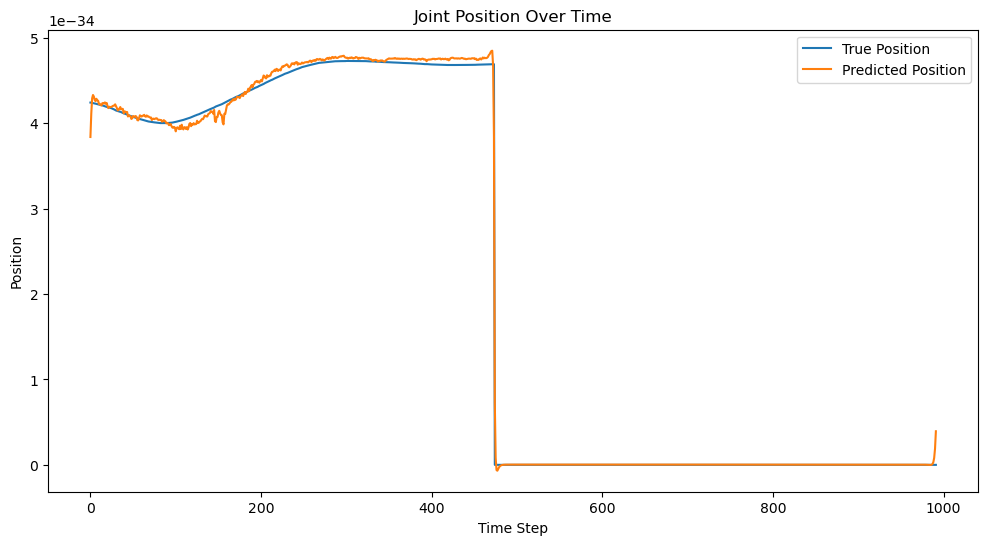

In [71]:
import matplotlib.pyplot as plt

# Select a sequence from the test set
X_sequence, Y_true_sequence, lengths = next(iter(test_loader))
sequence_idx = 0
length = lengths[sequence_idx]

X_sequence = X_sequence[sequence_idx:sequence_idx+1, :length].to(device)
Y_true_sequence = Y_true_sequence[sequence_idx:sequence_idx+1, :length].to(device)
lengths_sequence = lengths[sequence_idx:sequence_idx+1]

# Predict
model.eval()
with torch.no_grad():
    outputs, mask = model(X_sequence, lengths_sequence)
    
# Denormalize
def denormalize(data, mean, std):
    mean = mean.to(device).unsqueeze(0).unsqueeze(0)
    std = std.to(device).unsqueeze(0).unsqueeze(0)
    return data * std + mean

Y_true_denorm = denormalize(Y_true_sequence, Y_mean, Y_std)
Y_pred_denorm = denormalize(outputs, Y_mean, Y_std)

# Convert to CPU and numpy
Y_true_denorm = Y_true_denorm.squeeze(0).cpu().numpy()
Y_pred_denorm = Y_pred_denorm.squeeze(0).cpu().numpy()

# Plot true vs predicted positions for a joint
joint_idx = 0  # First joint
coordinate_idx = 0  # X-coordinate

plt.figure(figsize=(12, 6))
plt.plot(
    Y_true_denorm[:length, joint_idx * 3 + coordinate_idx],
    label='True Position',
)
plt.plot(
    Y_pred_denorm[:length, joint_idx * 3 + coordinate_idx],
    label='Predicted Position',
)
plt.title('Joint Position Over Time')
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.legend()
plt.show()


In [69]:
!jupyter nbconvert --to script Code/preprocessing/preprocess.ipynb


[NbConvertApp] Converting notebook Code/preprocessing/preprocess.ipynb to script
[NbConvertApp] Writing 16365 bytes to Code/preprocessing/preprocess.py
